In [101]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os

from kmodes.kmodes import KModes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [102]:
# 假设你的数据存储在DataFrame df
# 你的数据示例：
df = pd.read_csv(r"C:\Users\吴宇豪\Desktop\cardio_train.csv",sep=';') # 或其他方式载入
df.head()            #展示头部代码

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [103]:
df.info()          #输出每栏的数据格式

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [104]:
df.isnull().values.any()          #查看是否有数据缺失或者NAN

False

In [105]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
#处理数据中升高和体重的头部和尾部数据，能够使得预测更加精准。

In [106]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))
#查看数据中是否有舒张压大于收缩压的情况，并输出这种情况案例有多少
df.drop(df[(df['ap_hi'] < df['ap_lo'])].index,inplace=True)

Diastilic pressure is higher than systolic one in 1082 cases


In [107]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
#如上，处理舒张压和收缩压中的极端数据

In [108]:
df.describe()
#可以看出，删除了将近9千份有问题的数据后，数据变得更加‘干净’了

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000
mean,49893.854636,19468.563926,1.347303,164.555245,73.425961,125.764452,81.045051,1.350911,1.220232,0.085595,0.051869,0.803665,0.488159
std,28840.323823,2460.522833,0.476117,6.830490,11.615004,13.754923,8.237845,0.670020,0.567630,0.279767,0.221765,0.397228,0.499864
min,0.000000,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24864.750000,17677.000000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,49900.000000,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74744.250000,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,180.000000,106.000000,160.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
# 将年龄从原本的数据‘天‘，改为数据‘年‘
df['years'] = (df['age'] / 365).round().astype('int')
df.drop(['age'], axis='columns', inplace=True)
df.drop(['id'], axis='columns', inplace=True)
# 以5年为一个度量，区分年龄为不同的层次
df['age_bin'] = pd.cut(df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50',
                                      '50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])


In [110]:
# 定义新数据体质指数，将身高和体重转化为bmi
df['bmi'] = df['weight']/((df['height']/100)**2)
rating = []
for row in df['bmi']:
    if row < 18.5 :    rating.append(1) #体重过轻
    elif row > 18.5 and row < 23.9:  rating.append(2)#正常体重
    elif row > 23.9 and row < 27.9:  rating.append(3)#体重过重
    elif row > 27.9 and row < 49.9:  rating.append(4)#肥胖
    elif row > 49.9:  rating.append('Error')#数据有问题
        
    else:           rating.append('Not_Rated')

In [111]:
df['BMI_Class'] = rating

In [112]:
df["BMI_Class"].value_counts(normalize=True)

BMI_Class
3    0.376871
4    0.366727
2    0.254291
1    0.002112
Name: proportion, dtype: float64

In [113]:
#定义新数据，平均动脉压
df['MAP'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

In [114]:
map_values = []
for row in df['MAP']:
    if row < 69.9:    map_values.append(1) #低平均动脉压
    elif row > 69.9 and row  < 104.9:   map_values.append(2)#正常平均动脉压
    elif row > 104.9 and row < 119.9:  map_values.append(3)#高动脉压
    elif row > 119.9:  map_values.append(4)
        
    else:           map_values.append('Not_Rated')

In [115]:
df['MAP_Class'] = map_values

In [116]:
# 查看经过处理后新的表格
df= df[["gender","height","weight","bmi","ap_hi","ap_lo","MAP","years","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio"]]
df.head()

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,2,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,4,3,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,2,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,4,3,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0


In [117]:
# 只保留性别，年龄分层，bmi，map，胆固醇高低，抽烟，喝酒，活动数据。
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio",]]
df.head(50)

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,2,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,4,3,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,2,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,4,3,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0
5,1,151,67.0,29.384676,120,80,93.333333,60,55-60,4,2,2,2,0,0,0
6,1,157,93.0,37.729725,130,80,96.666667,61,60-65,4,2,3,1,0,1,0
7,2,178,95.0,29.983588,130,90,103.333333,62,60-65,4,2,3,3,0,1,1
8,1,158,71.0,28.440955,110,70,83.333333,48,45-50,4,2,1,1,0,1,0
9,1,164,68.0,25.282570,110,60,76.666667,54,50-55,3,2,1,1,0,0,0


In [118]:
#按字典序进行编码
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head(50)

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,0,0,0,0,1,0
1,0,4,3,1,2,0,0,1,1
2,0,4,1,0,2,0,0,0,1
3,1,3,3,1,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0
5,0,5,3,0,1,1,0,0,0
6,0,6,3,0,2,0,0,1,0
7,1,6,3,0,2,2,0,1,1
8,0,3,3,0,0,0,0,1,0
9,0,4,2,0,0,0,0,0,0


In [119]:
#分别查询男女性别的数据
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")
df_male.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,4,3,1,2,0,0,1,1
2,0,4,1,0,2,0,0,0,1
4,0,3,1,0,0,0,0,0,0
5,0,5,3,0,1,1,0,0,0
6,0,6,3,0,2,0,0,1,0


In [120]:
df_female.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,0,0,0,0,1,0
3,1,3,3,1,0,0,0,1,1
7,1,6,3,0,2,2,0,1,1
11,1,4,1,0,0,0,0,1,0
12,1,2,1,0,0,0,0,0,0


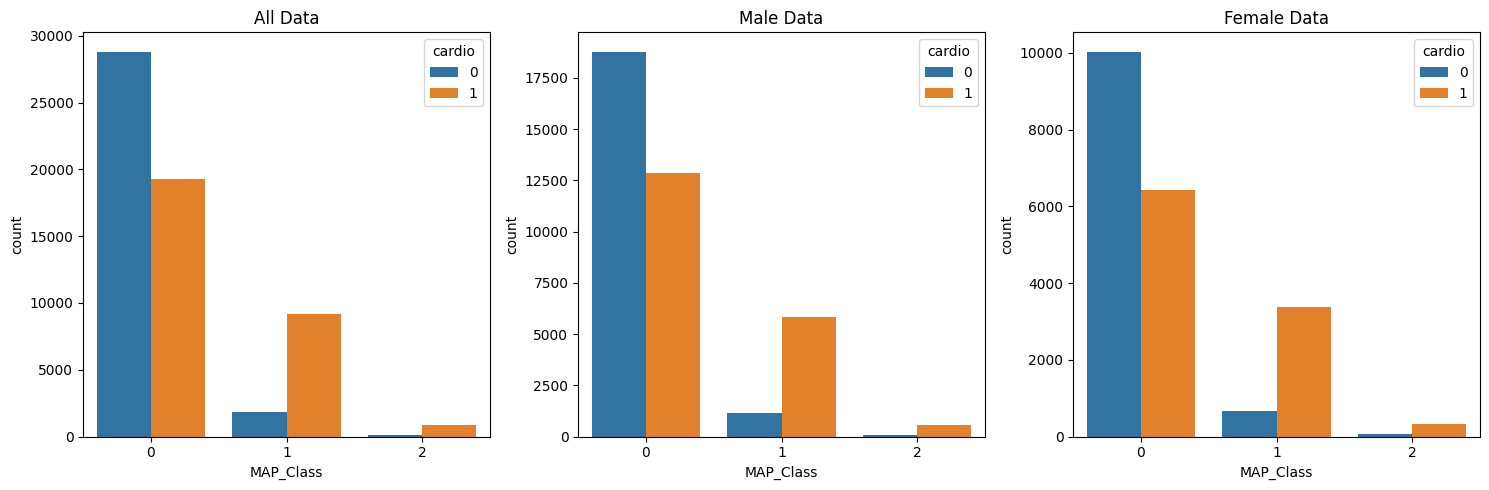

In [121]:
#展示不同性别，在不同的平均动脉压下患有心血管疾病人数的直方图
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['MAP_Class'],order=df_cat['MAP_Class'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['MAP_Class'],order=df_male['MAP_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['MAP_Class'],order=df_female['MAP_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#可以看出，性别并不影响到平均动脉压的高低导致的心血管疾病概率

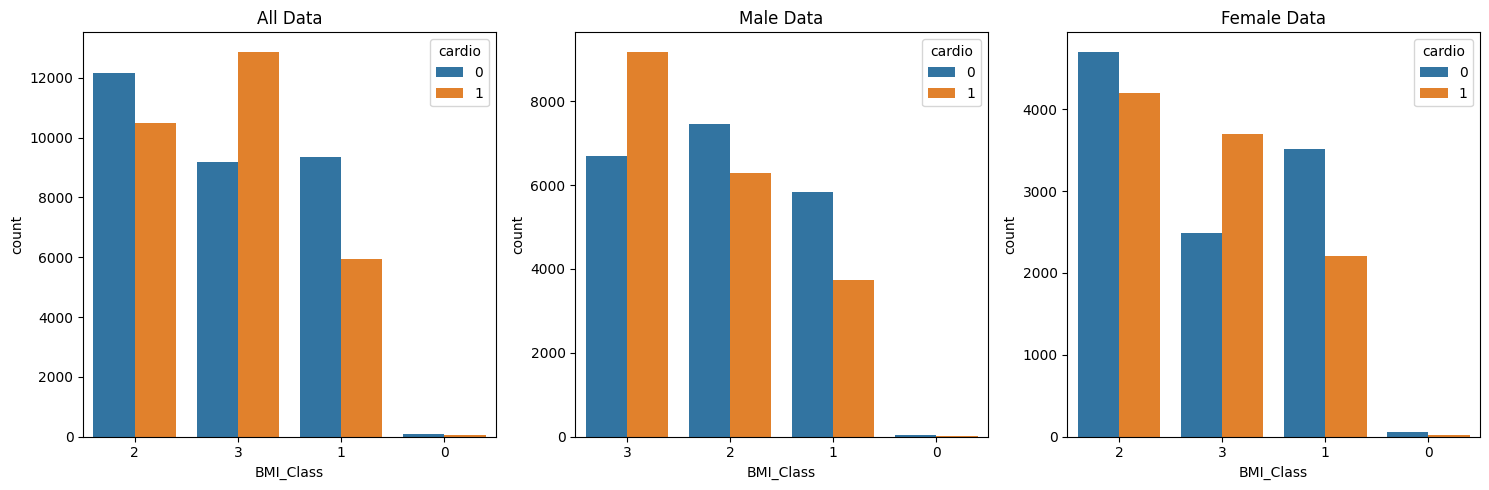

In [122]:
#展示不同性别在不同体质指数下患有心血管疾病的概率
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['BMI_Class'],order=df_cat['BMI_Class'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['BMI_Class'],order=df_male['BMI_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['BMI_Class'],order=df_female['BMI_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#看的出来，超重与肥胖数据下，男女的心血管疾病患病率有所不同

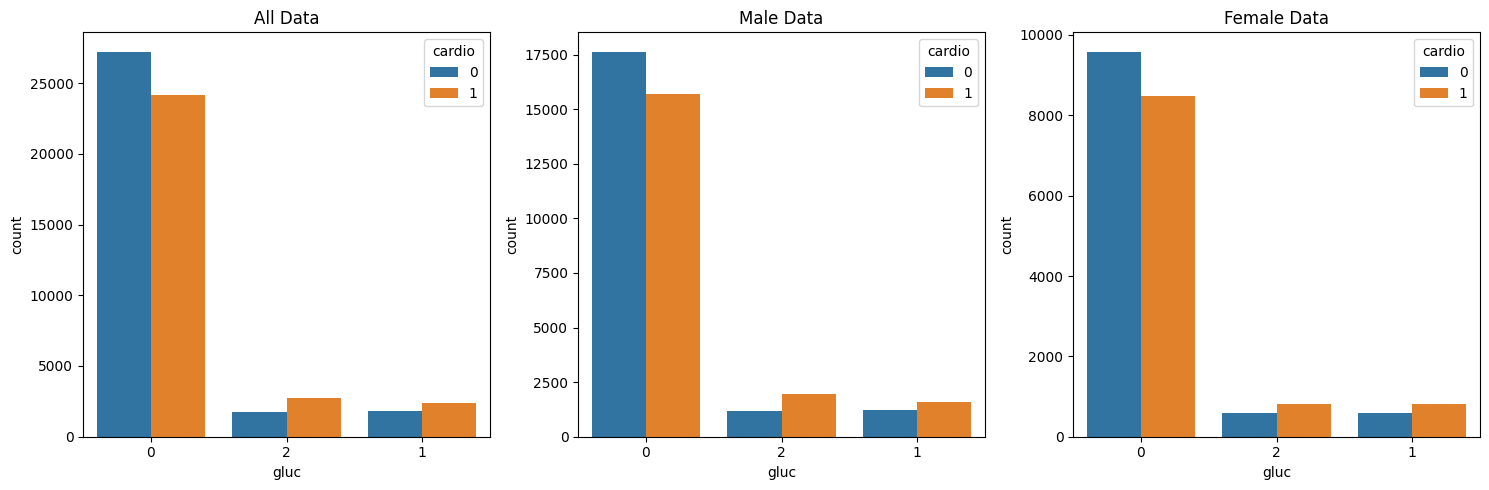

In [123]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['gluc'],order=df_cat['gluc'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['gluc'],order=df_male['gluc'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['gluc'],order=df_female['gluc'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#酒精摄入导致的心血管疾病不受性别影响

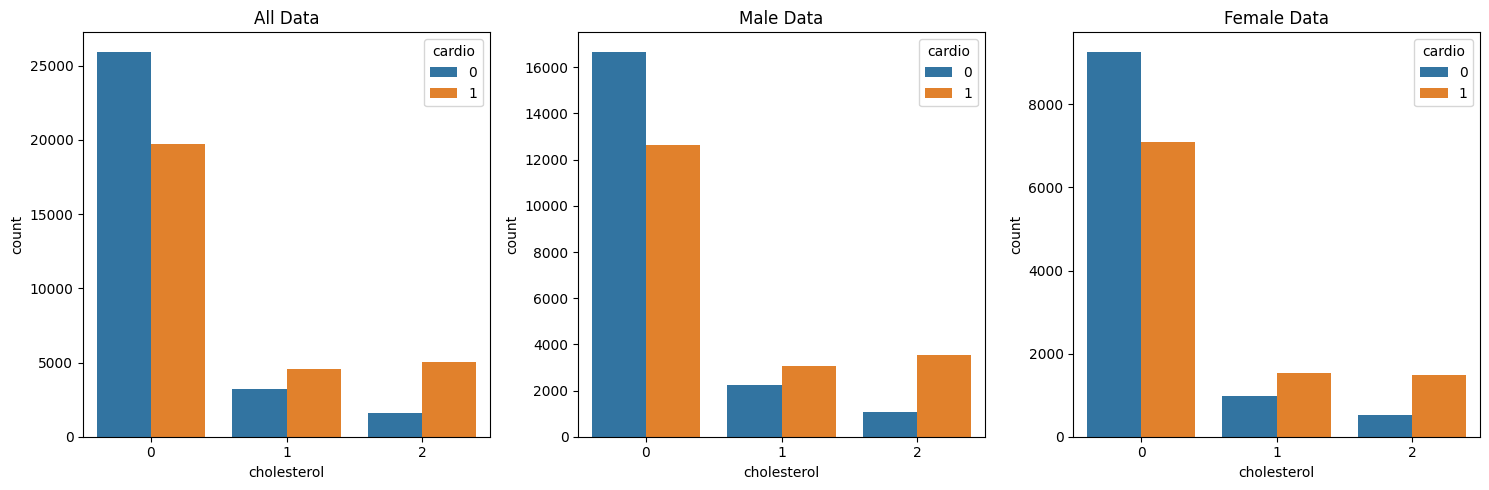

In [124]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['cholesterol'],order=df_cat['cholesterol'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['cholesterol'],order=df_male['cholesterol'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['cholesterol'],order=df_female['cholesterol'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#胆固醇摄入量也一样

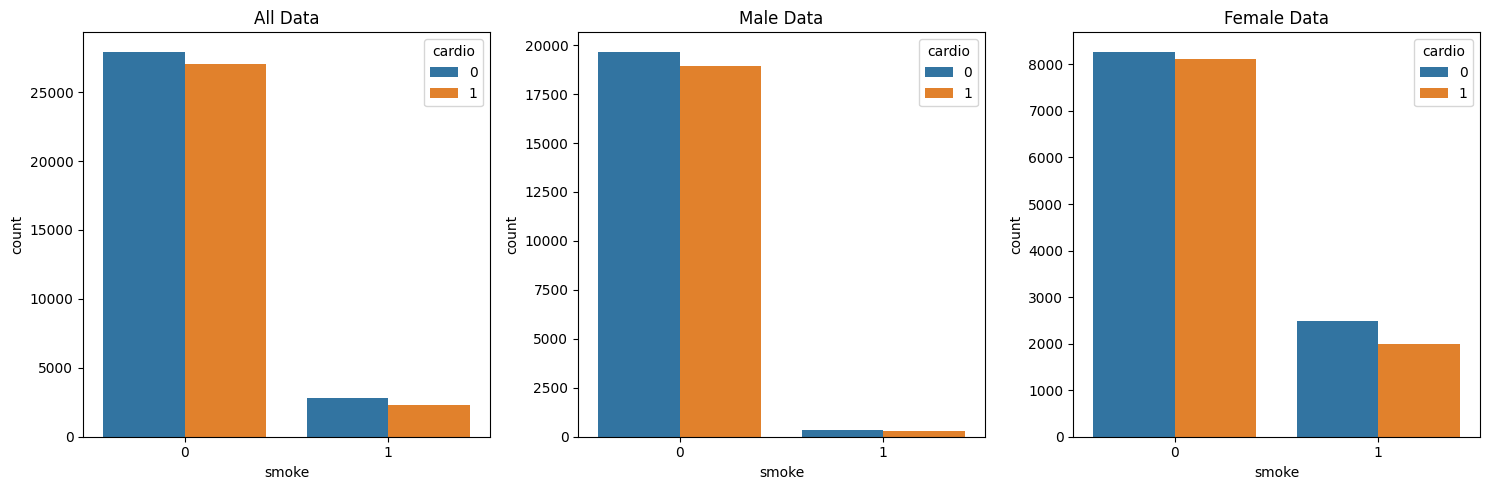

In [125]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['smoke'],order=df_cat['smoke'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['smoke'],order=df_male['smoke'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['smoke'],order=df_female['smoke'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#吸烟类似

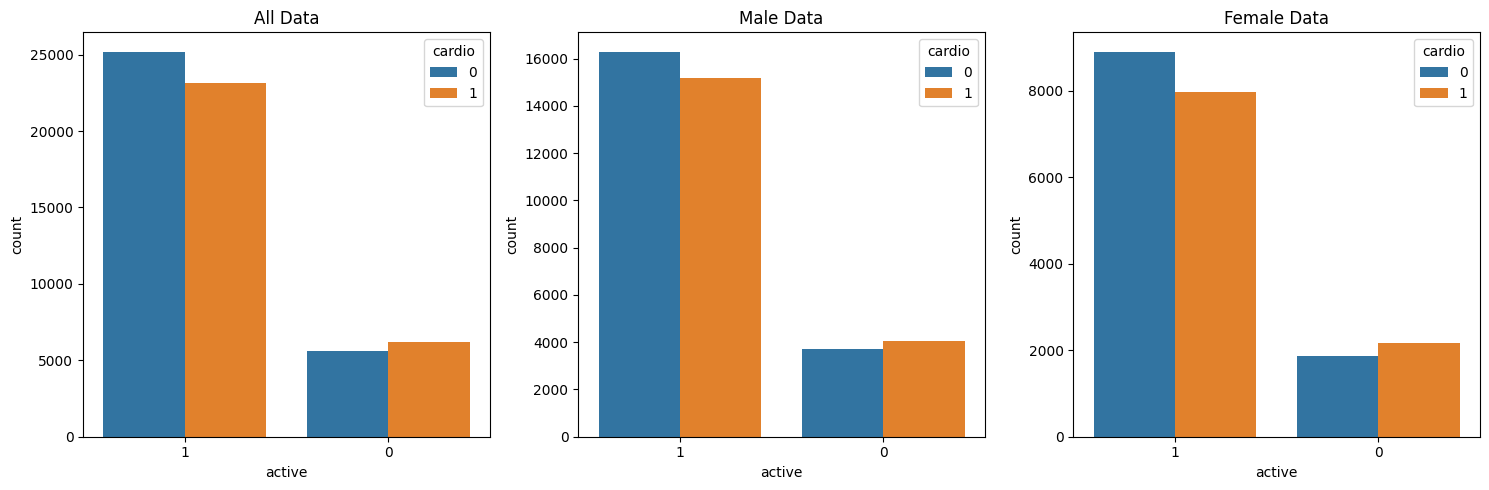

In [126]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['active'],order=df_cat['active'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['active'],order=df_male['active'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['active'],order=df_female['active'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#活动类似

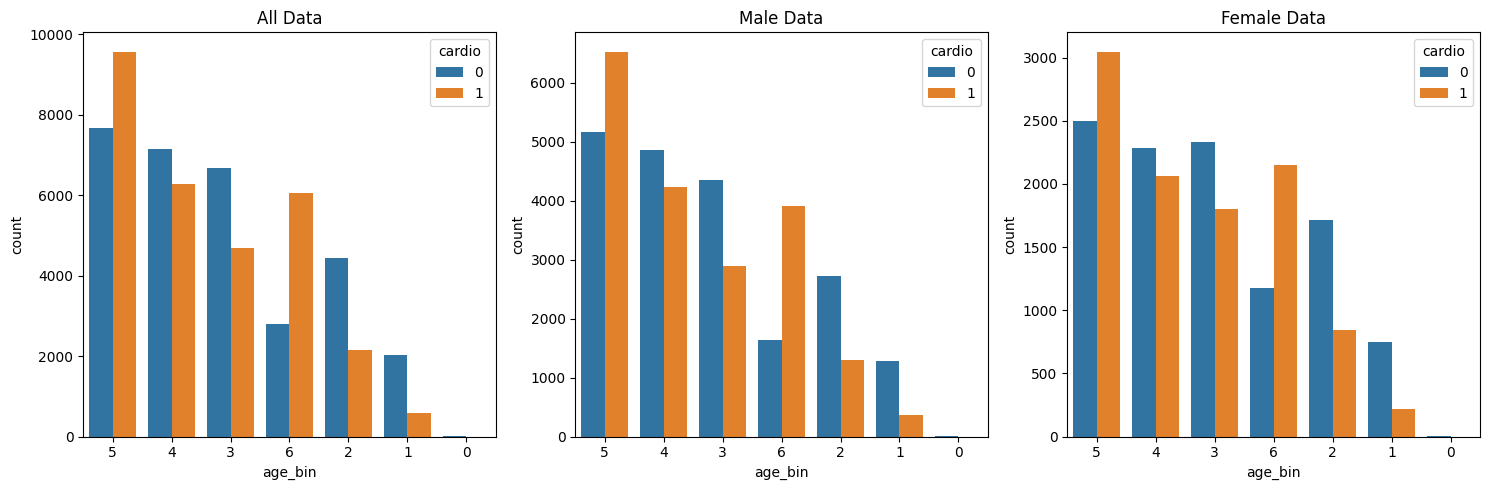

In [127]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_cat['age_bin'],order=df_cat['age_bin'].value_counts().index,hue=df_cat['cardio'],ax=axs[0])
sns.countplot(x=df_male['age_bin'],order=df_male['age_bin'].value_counts().index,hue=df_male['cardio'],ax=axs[1])
sns.countplot(x=df_female['age_bin'],order=df_female['age_bin'].value_counts().index,hue=df_female['cardio'],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()
#在45-50年这个层次内的人可能更容易患心血管疾病

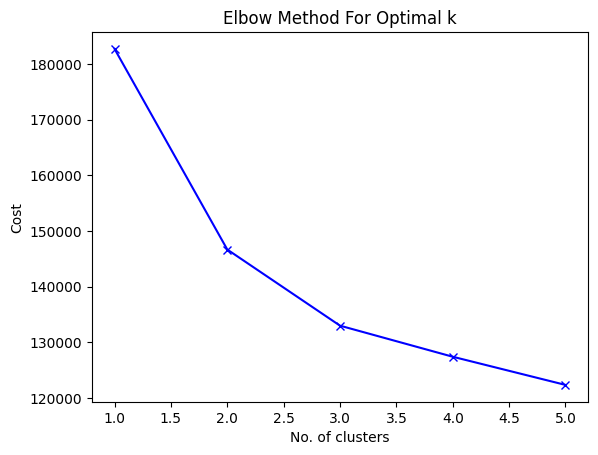

In [128]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

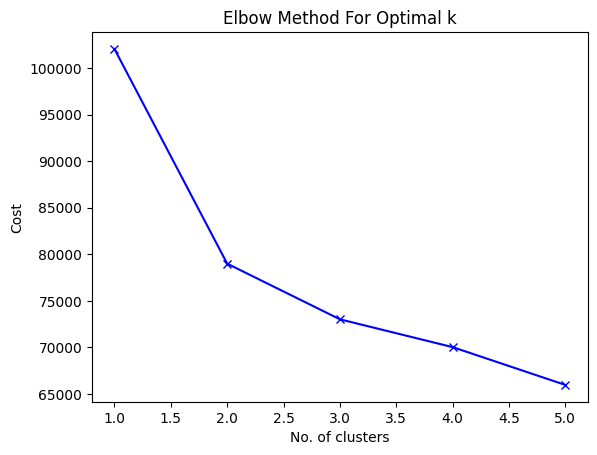

In [129]:
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

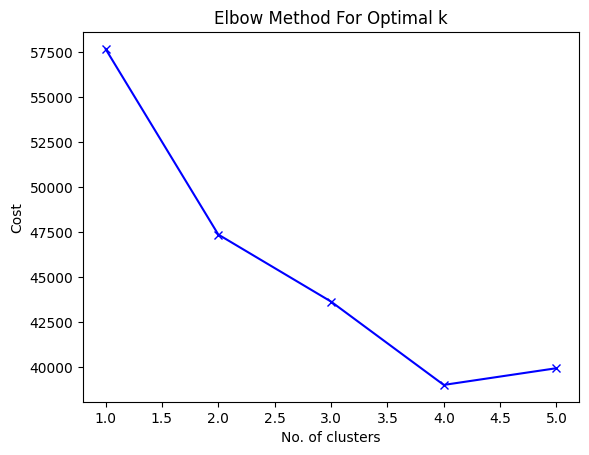

In [130]:
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [131]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

array([1, 0, 0, ..., 0, 1, 0], dtype=uint16)

In [132]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [133]:
df_female.insert(0,"Cluster", clusters_huang_1, True)

# female DataFrame with Clusters
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,1,3,1,0,0,0,0,1,0
3,0,1,3,3,1,0,0,0,1,1
7,0,1,6,3,0,2,2,0,1,1
11,1,1,4,1,0,0,0,0,1,0
12,1,1,2,1,0,0,0,0,0,0


In [134]:
df_male.insert(0, "Cluster", clusters_huang_2, True)

# female DataFrame with Clusters
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,1,0,4,3,1,2,0,0,1,1
2,0,0,4,1,0,2,0,0,0,1
4,0,0,3,1,0,0,0,0,0,0
5,1,0,5,3,0,1,1,0,0,0
6,0,0,6,3,0,2,0,0,1,0


In [135]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,3,0,4,3,1,2,0,0,1,1
2,2,0,4,1,0,2,0,0,0,1
4,2,0,3,1,0,0,0,0,0,0
5,3,0,5,3,0,1,1,0,0,0
6,2,0,6,3,0,2,0,0,1,0


In [136]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,1,3,1,0,0,0,0,1,0
1,0,1,3,3,1,0,0,0,1,1
2,0,1,6,3,0,2,2,0,1,1
3,1,1,4,1,0,0,0,0,1,0
4,1,1,2,1,0,0,0,0,0,0
5,1,1,5,1,0,0,0,1,1,0
6,1,1,4,3,0,0,0,0,1,0
7,0,1,1,2,0,0,0,0,1,0
8,0,1,5,2,0,0,2,0,0,0
9,0,1,5,2,1,2,0,0,0,1


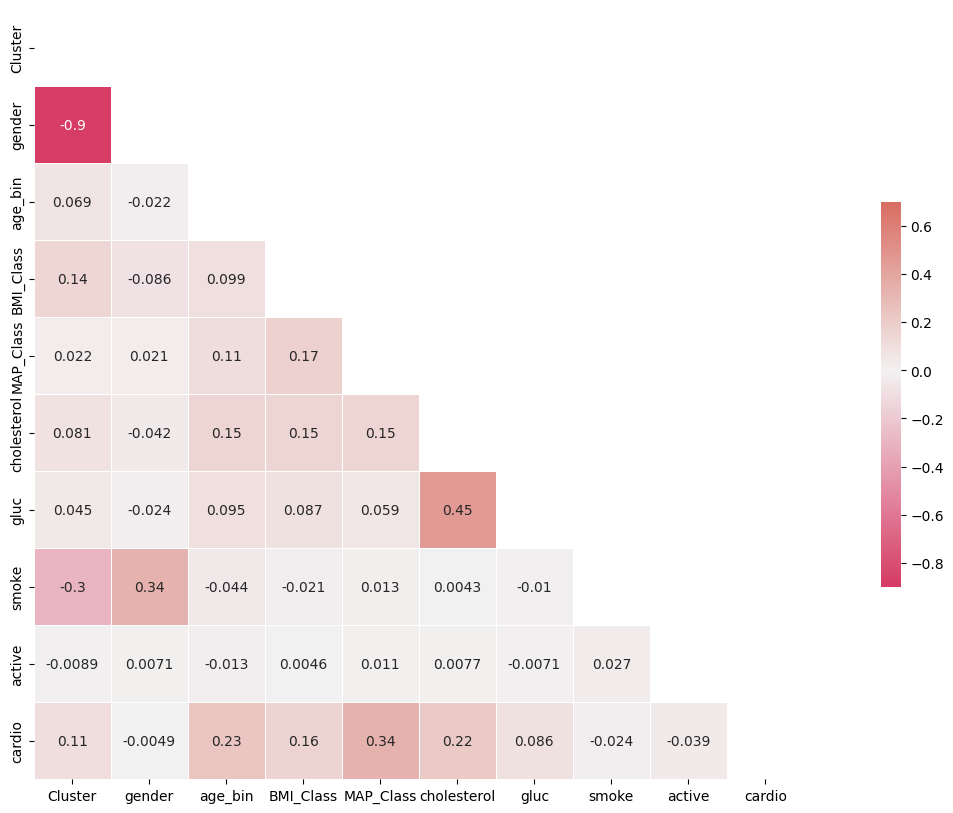

In [137]:
corr = df_clusters.corr()
cmap = sns.diverging_palette(2, 15, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

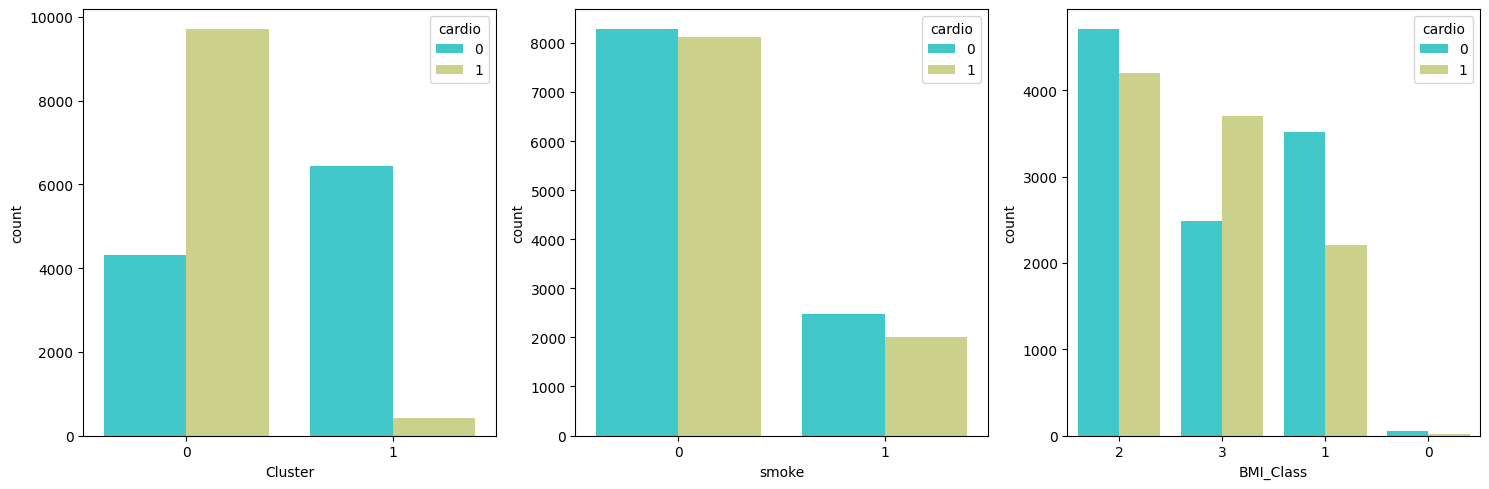

In [138]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_female['Cluster'],order=df_female['Cluster'].value_counts().index,hue=df_female['cardio'],ax=axs[0],palette='rainbow')
sns.countplot(x=df_female['smoke'],order=df_female['smoke'].value_counts().index,hue=df_female['cardio'],ax=axs[1],palette='rainbow')
sns.countplot(x=df_female['BMI_Class'],order=df_female['BMI_Class'].value_counts().index,hue=df_female['cardio'],ax=axs[2],palette='rainbow')

plt.tight_layout()
plt.show()

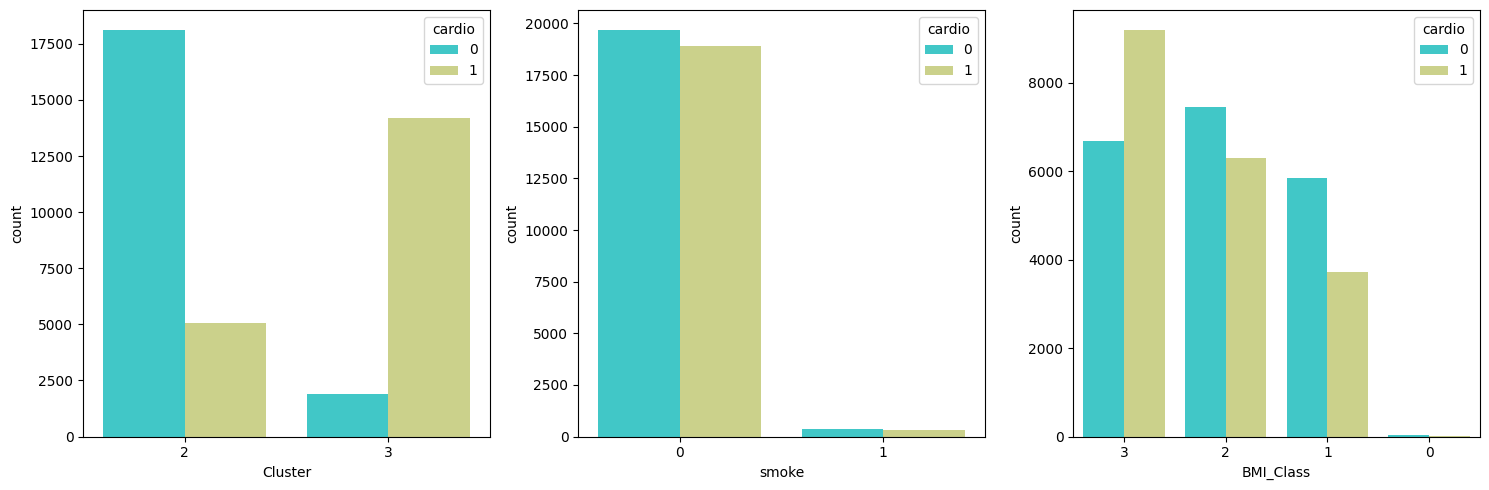

In [139]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df_male['Cluster'],order=df_male['Cluster'].value_counts().index,hue=df_male['cardio'],ax=axs[0],palette='rainbow')
sns.countplot(x=df_male['smoke'],order=df_male['smoke'].value_counts().index,hue=df_male['cardio'],ax=axs[1],palette='rainbow')
sns.countplot(x=df_male['BMI_Class'],order=df_male['BMI_Class'].value_counts().index,hue=df_male['cardio'],ax=axs[2],palette='rainbow')

plt.tight_layout()
plt.show()


In [140]:
df_female_c0 = df_female[df_female["Cluster"] == 0]
df_female_c1 = df_female[df_female["Cluster"] == 1]


df_female_c0.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
3,0,1,3,3,1,0,0,0,1,1
7,0,1,6,3,0,2,2,0,1,1
28,0,1,1,2,0,0,0,0,1,0
29,0,1,5,2,0,0,2,0,0,0
34,0,1,5,2,1,2,0,0,0,1


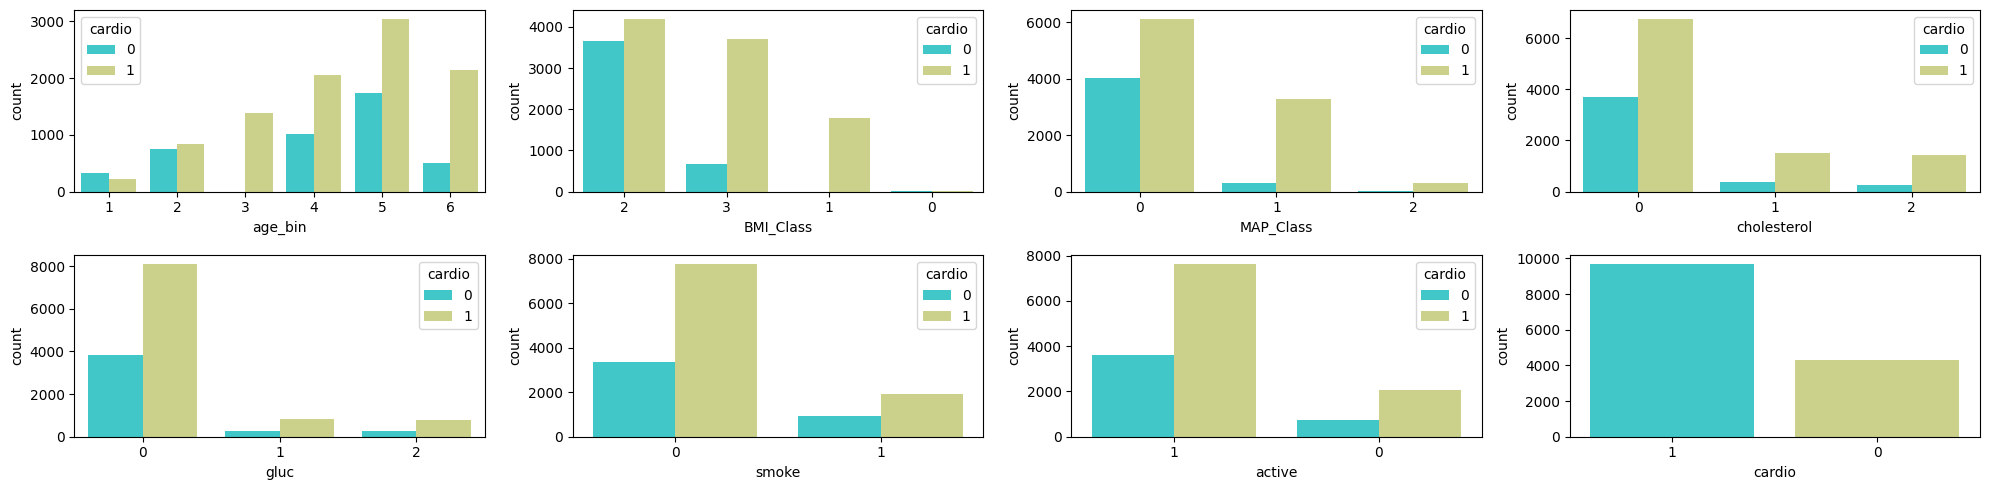

In [141]:
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_female_c0['age_bin'],hue=df_female_c0['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_female_c0['BMI_Class'],order=df_female_c0['BMI_Class'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_female_c0['MAP_Class'],order=df_female_c0['MAP_Class'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_female_c0['cholesterol'],order=df_female_c0['cholesterol'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_female_c0['gluc'],order=df_female_c0['gluc'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_female_c0['smoke'],order=df_female_c0['smoke'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_female_c0['active'],order=df_female_c0['active'].value_counts().index,hue=df_female_c0['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_female_c0['cardio'],order=df_female_c0['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

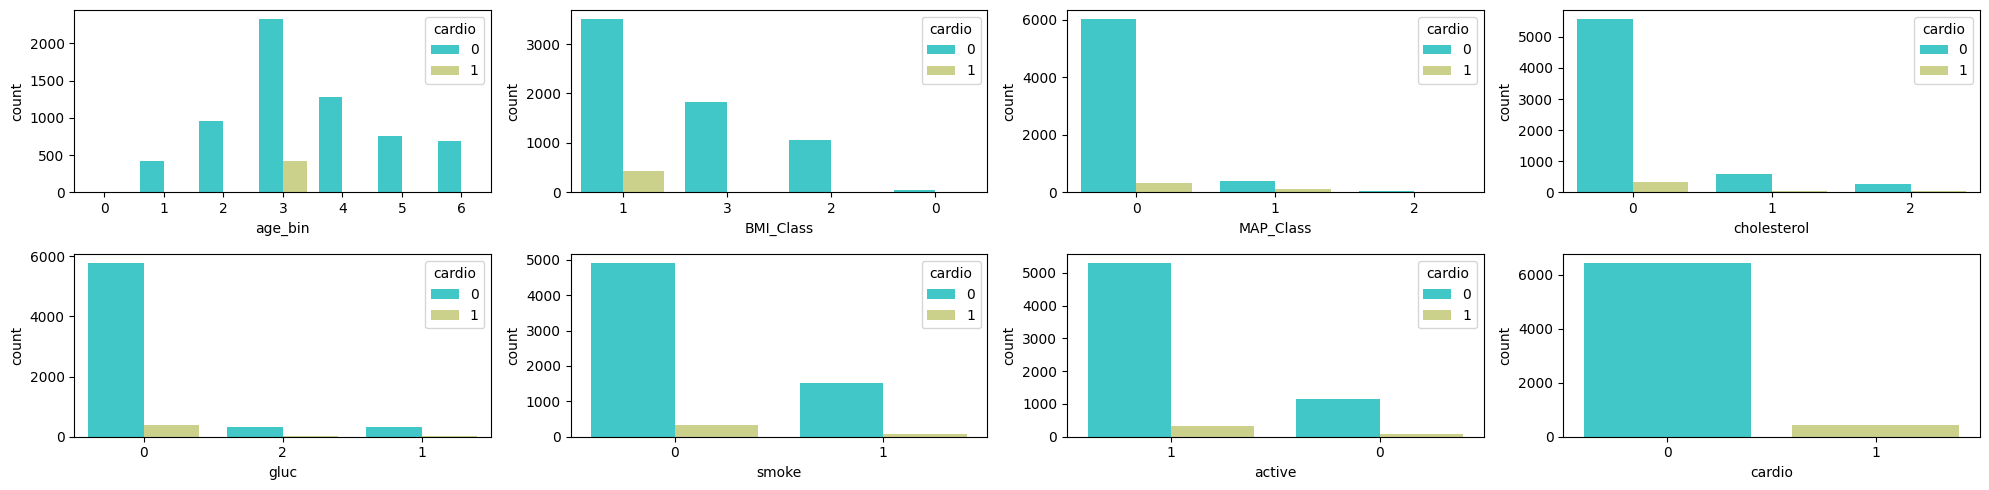

In [142]:
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_female_c1['age_bin'],hue=df_female_c1['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_female_c1['BMI_Class'],order=df_female_c1['BMI_Class'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_female_c1['MAP_Class'],order=df_female_c1['MAP_Class'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_female_c1['cholesterol'],order=df_female_c1['cholesterol'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_female_c1['gluc'],order=df_female_c1['gluc'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_female_c1['smoke'],order=df_female_c1['smoke'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_female_c1['active'],order=df_female_c1['active'].value_counts().index,hue=df_female_c1['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_female_c1['cardio'],order=df_female_c1['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

In [143]:
# separating clusters
df_male_c2 = df_male[df_male["Cluster"] == 2]
df_male_c3 = df_male[df_male["Cluster"] == 3]


df_male_c2.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,23145.0,23145.0,23145.000000,23145.000000,23145.000000,23145.000000,23145.000000,23145.000000,23145.000000,23145.000000
mean,2.0,0.0,3.702139,1.914409,0.112162,0.250508,0.178570,0.016764,0.808036,0.217974
std,0.0,0.0,1.368479,0.702430,0.337409,0.568940,0.515696,0.128388,0.393853,0.412878
min,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,0.0,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.0,0.0,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.0,0.0,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.0,0.0,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


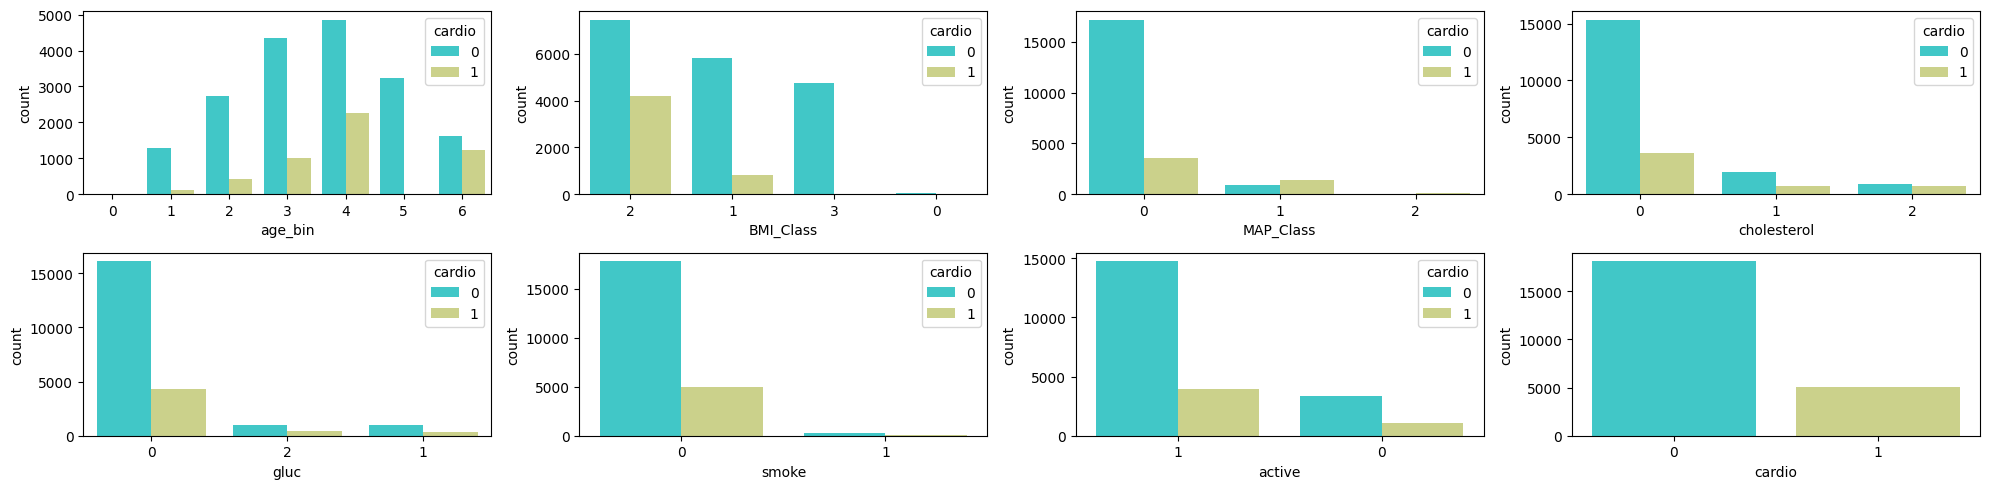

In [144]:
# for df_male_c2
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_male_c2['age_bin'],hue=df_male_c2['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_male_c2['BMI_Class'],order=df_male_c2['BMI_Class'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_male_c2['MAP_Class'],order=df_male_c2['MAP_Class'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_male_c2['cholesterol'],order=df_male_c2['cholesterol'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_male_c2['gluc'],order=df_male_c2['gluc'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_male_c2['smoke'],order=df_male_c2['smoke'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_male_c2['active'],order=df_male_c2['active'].value_counts().index,hue=df_male_c2['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_male_c2['cardio'],order=df_male_c2['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()

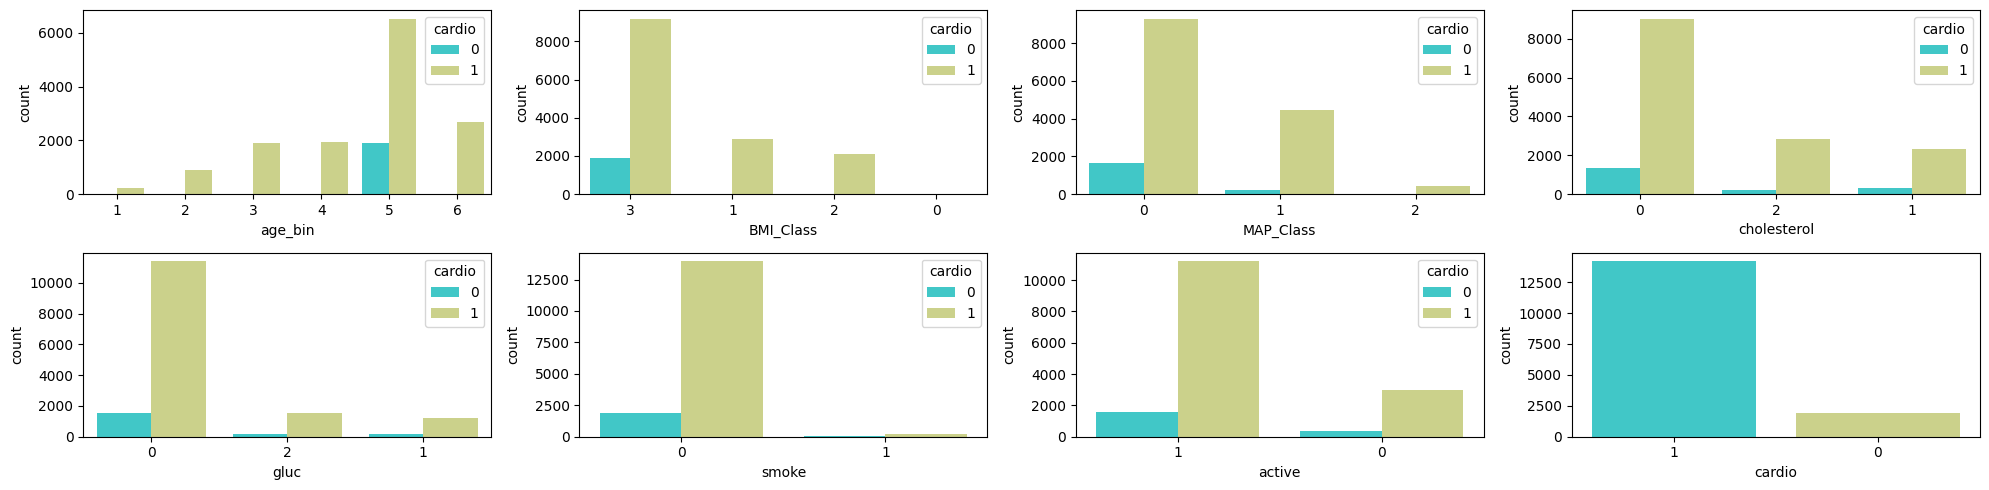

In [145]:
# for df_male_c3
f, axs = plt.subplots(2,4,figsize = (20,5))
sns.countplot(x=df_male_c3['age_bin'],hue=df_male_c3['cardio'],ax=axs[0,0],palette='rainbow')
sns.countplot(x=df_male_c3['BMI_Class'],order=df_male_c3['BMI_Class'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,1],palette='rainbow')
sns.countplot(x=df_male_c3['MAP_Class'],order=df_male_c3['MAP_Class'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,2],palette='rainbow')
sns.countplot(x=df_male_c3['cholesterol'],order=df_male_c3['cholesterol'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[0,3],palette='rainbow')
sns.countplot(x=df_male_c3['gluc'],order=df_male_c3['gluc'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,0],palette='rainbow')
sns.countplot(x=df_male_c3['smoke'],order=df_male_c3['smoke'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,1],palette='rainbow')
sns.countplot(x=df_male_c3['active'],order=df_male_c3['active'].value_counts().index,hue=df_male_c3['cardio'],ax=axs[1,2],palette='rainbow')
sns.countplot(x=df_male_c3['cardio'],order=df_male_c3['cardio'].value_counts().index,ax=axs[1,3],palette='rainbow')

plt.tight_layout()
plt.show()


In [146]:
#list of columns
my_list = df_clusters.columns.values.tolist()
my_list

['Cluster',
 'gender',
 'age_bin',
 'BMI_Class',
 'MAP_Class',
 'cholesterol',
 'gluc',
 'smoke',
 'active',
 'cardio']

In [147]:
# function to calc % in column
def function(dataframe,valor):
    my_list = dataframe.columns.values.tolist()
    for x in my_list[2:]:
        for y in range(valor):
            percentages = round(((dataframe[x]== y) & (dataframe['cardio']== 1)).sum()/ (dataframe[x]== y).sum()* 100, 2)
            print(percentages)

In [148]:
# applying the function
# there must be a better way to do that though...
function(df_male_c3,8)

nan
100.0
100.0
100.0
100.0
77.27
100.0
nan
100.0
100.0
100.0
82.72
nan
nan
nan
nan
84.91
94.75
95.32
nan
nan
nan
nan
nan
86.84
87.42
92.87
nan
nan
nan
nan
nan
88.1
87.45
88.51
nan
nan
nan
nan
nan
88.09
87.91
nan
nan
nan
nan
nan
nan
89.23
87.78
nan
nan
nan
nan
nan
nan
0.0
100.0
nan
nan
nan
nan
nan
nan


In [149]:
# dictionary with list object in values
# placed by hand...
details = {
    'age_bin_0':[0.0, 0.0, 0.0, 0.0],
    'age_bin_1':[7.62, 92.44, 8.48, 100.0],
    'age_bin_2':[12.94, 92.46, 13.73, 100.0],
    'age_bin_3':[19.73, 92.21, 16.17, 100.0],
    'age_bin_4':[36.29, 100.0, 34.82, 100.0],
    'age_bin_5':[16.6, 84.63, 0.0, 76.59],
    'age_bin_6':[38.56, 93.29, 38.23, 100.0],
    
    'BMI_Class_0':[12.07, 100.0, 9.76, 100.0],
    'BMI_Class_1':[31.1, 100.0, 30.77, 100.0],
    'BMI_Class_2':[8.8, 86.34, 0.0, 78.11],
    'BMI_Class_3':[32.73, 94.86, 22.18, 100.0],
    'BMI_Class_4':[37.62, 94.29, 27.91, 100.0],
    'BMI_Class_5':[66.67, 100.0, 31.54, 100.0],
    
    'MAP_Class_0':[12.55, 85.71, 10.2, 70.29],
    'MAP_Class_1':[11.94, 75.34, 10.1, 75.49],
    'MAP_Class_2':[25.28, 100.0, 17.03, 82.55],
    'MAP_Class_3':[19.89, 85.49, 46.41, 94.35],
    'MAP_Class_4':[60.13, 97.42, 59.48, 97.17],
    'MAP_Class_5':[61.4, 95.04, 58.67, 97.95],
    
    'cholesterol_0':[22.06, 89.16, 18.84, 85.04],
    'cholesterol_1':[29.81, 92.4, 26.92, 90.33],
    'cholesterol_2':[48.41, 92.0, 44.38, 95.2],
    
    'gluc_0' : [23.69, 90.18, 20.78, 86.95],
    'gluc_1' : [28.45, 90.39, 24.72, 90.59],
    'gluc_2' : [31.87, 89.4, 31.12, 91.51],
    
    'smoke_0' : [25.93, 90.48, 21.73, 87.7],
    'smoke_1' : [18.9, 88.86, 19.49, 88.43],
    
    'active_0' : [29.93, 91.7, 24.19, 88.99],
    'active_1' : [23.16, 89.73, 21.1, 87.38],
}

In [150]:
# creating a Dataframe object from dictionary 
# with custom indexing
df_pc = pd.DataFrame(details, index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
df_pc.head()

,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6,BMI_Class_0,BMI_Class_1,BMI_Class_2,...,cholesterol_0,cholesterol_1,cholesterol_2,gluc_0,gluc_1,gluc_2,smoke_0,smoke_1,active_0,active_1
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56,12.07,31.10,8.80,...,22.06,29.81,48.41,23.69,28.45,31.87,25.93,18.90,29.93,23.16
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29,100.00,100.00,86.34,...,89.16,92.40,92.00,90.18,90.39,89.40,90.48,88.86,91.70,89.73
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23,9.76,30.77,0.00,...,18.84,26.92,44.38,20.78,24.72,31.12,21.73,19.49,24.19,21.10
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00,100.00,100.00,78.11,...,85.04,90.33,95.20,86.95,90.59,91.51,87.70,88.43,88.99,87.38


In [151]:
# creating separate dfs
df_agebins = df_pc.loc[:,"age_bin_0":"age_bin_6"]
df_bmi = df_pc.loc[:,"BMI_Class_0":"BMI_Class_5"]
df_map = df_pc.loc[:,"MAP_Class_0":"MAP_Class_5"]
df_chol = df_pc.loc[:,"cholesterol_0":"cholesterol_2"]
df_gluc = df_pc.loc[:,"gluc_0":"gluc_2"]
df_smokers = df_pc.loc[:,"smoke_0":"smoke_1"]
df_actives = df_pc.loc[:,"active_0":"active_1"]

In [152]:
df_agebins.head()

,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00


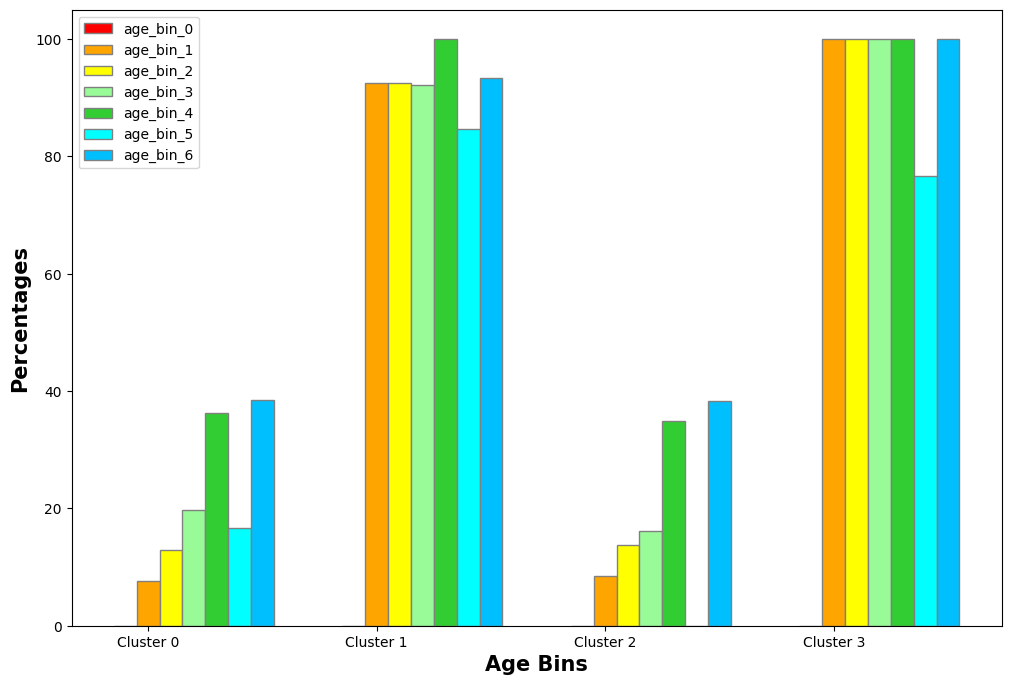

In [153]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
age_bin_0 = df_agebins['age_bin_0']
age_bin_1 = df_agebins['age_bin_1']
age_bin_2 = df_agebins['age_bin_2']
age_bin_3 = df_agebins['age_bin_3']
age_bin_4 = df_agebins['age_bin_4']
age_bin_5 = df_agebins['age_bin_5']
age_bin_6 = df_agebins['age_bin_6']
 
# Set position of bar on X axis
br1 = np.arange(len(age_bin_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]


 # Make the plot
plt.bar(br1, age_bin_0, color ='red', width = barWidth,edgecolor ='grey', label ='age_bin_0')
plt.bar(br2, age_bin_1, color ='orange', width = barWidth,edgecolor ='grey', label ='age_bin_1')
plt.bar(br3, age_bin_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='age_bin_2')
plt.bar(br4, age_bin_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='age_bin_3')
plt.bar(br5, age_bin_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='age_bin_4')
plt.bar(br6, age_bin_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='age_bin_5')
plt.bar(br7, age_bin_6, color ='deepskyblue', width = barWidth,edgecolor ='grey', label ='age_bin_6')

 
# Adding Xticks
plt.xlabel('Age Bins', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(age_bin_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [154]:
df_bmi.head()

,BMI_Class_0,BMI_Class_1,BMI_Class_2,BMI_Class_3,BMI_Class_4,BMI_Class_5
Cluster 0,12.07,31.10,8.80,32.73,37.62,66.67
Cluster 1,100.00,100.00,86.34,94.86,94.29,100.00
Cluster 2,9.76,30.77,0.00,22.18,27.91,31.54
Cluster 3,100.00,100.00,78.11,100.00,100.00,100.00


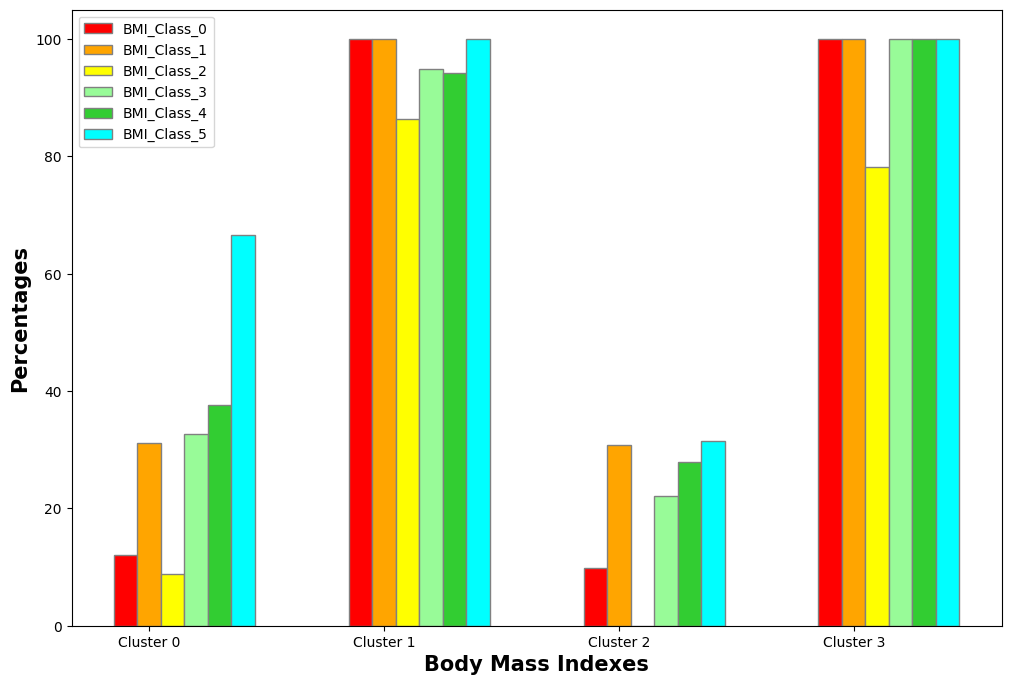

In [155]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
BMI_Class_0 = df_bmi['BMI_Class_0']
BMI_Class_1 = df_bmi['BMI_Class_1']
BMI_Class_2 = df_bmi['BMI_Class_2']
BMI_Class_3 = df_bmi['BMI_Class_3']
BMI_Class_4 = df_bmi['BMI_Class_4']
BMI_Class_5 = df_bmi['BMI_Class_5']

 # Set position of bar on X axis
br1 = np.arange(len(BMI_Class_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


# Make the plot
plt.bar(br1, BMI_Class_0, color ='red', width = barWidth,edgecolor ='grey', label ='BMI_Class_0')
plt.bar(br2, BMI_Class_1, color ='orange', width = barWidth,edgecolor ='grey', label ='BMI_Class_1')
plt.bar(br3, BMI_Class_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='BMI_Class_2')
plt.bar(br4, BMI_Class_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='BMI_Class_3')
plt.bar(br5, BMI_Class_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='BMI_Class_4')
plt.bar(br6, BMI_Class_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='BMI_Class_5')

 # Adding Xticks
plt.xlabel('Body Mass Indexes', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(BMI_Class_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [156]:
df_map.head()

,MAP_Class_0,MAP_Class_1,MAP_Class_2,MAP_Class_3,MAP_Class_4,MAP_Class_5
Cluster 0,12.55,11.94,25.28,19.89,60.13,61.40
Cluster 1,85.71,75.34,100.00,85.49,97.42,95.04
Cluster 2,10.20,10.10,17.03,46.41,59.48,58.67
Cluster 3,70.29,75.49,82.55,94.35,97.17,97.95


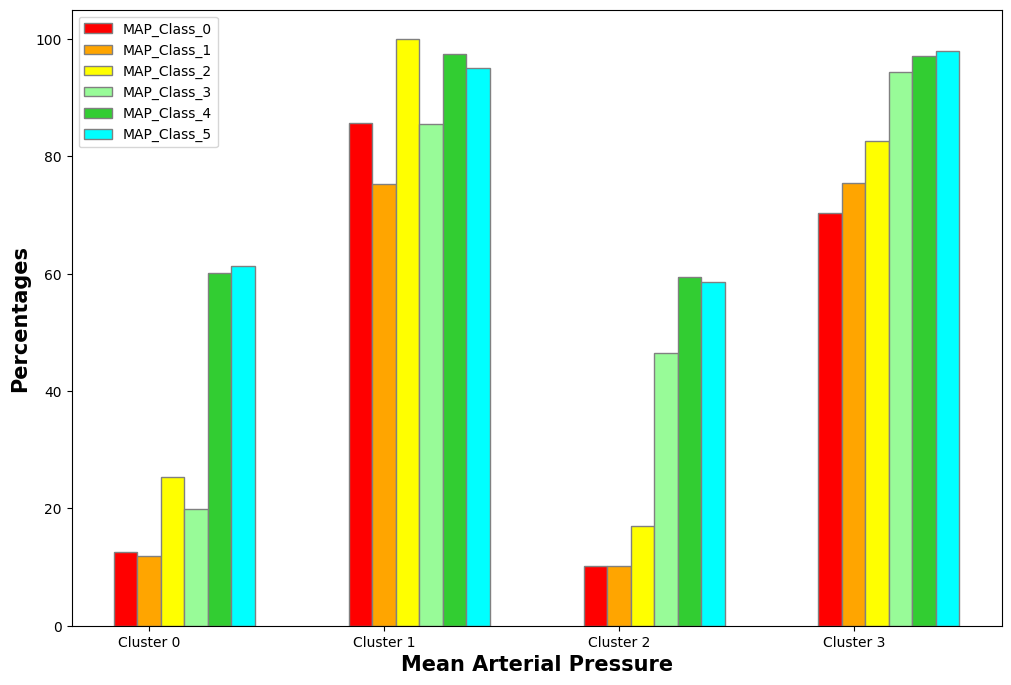

In [157]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
MAP_Class_0 = df_map['MAP_Class_0']
MAP_Class_1 = df_map['MAP_Class_1']
MAP_Class_2 = df_map['MAP_Class_2']
MAP_Class_3 = df_map['MAP_Class_3']
MAP_Class_4 = df_map['MAP_Class_4']
MAP_Class_5 = df_map['MAP_Class_5']

 # Set position of bar on X axis
br1 = np.arange(len(MAP_Class_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


# Make the plot
plt.bar(br1, MAP_Class_0, color ='red', width = barWidth,edgecolor ='grey', label ='MAP_Class_0')
plt.bar(br2, MAP_Class_1, color ='orange', width = barWidth,edgecolor ='grey', label ='MAP_Class_1')
plt.bar(br3, MAP_Class_2, color ='yellow', width = barWidth,edgecolor ='grey', label ='MAP_Class_2')
plt.bar(br4, MAP_Class_3, color ='palegreen', width = barWidth,edgecolor ='grey', label ='MAP_Class_3')
plt.bar(br5, MAP_Class_4, color ='limegreen', width = barWidth,edgecolor ='grey', label ='MAP_Class_4')
plt.bar(br6, MAP_Class_5, color ='aqua', width = barWidth,edgecolor ='grey', label ='MAP_Class_5')

 # Adding Xticks
plt.xlabel('Mean Arterial Pressure', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(MAP_Class_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.legend()
plt.show()

In [158]:
df_chol.head()

,cholesterol_0,cholesterol_1,cholesterol_2
Cluster 0,22.06,29.81,48.41
Cluster 1,89.16,92.40,92.00
Cluster 2,18.84,26.92,44.38
Cluster 3,85.04,90.33,95.20


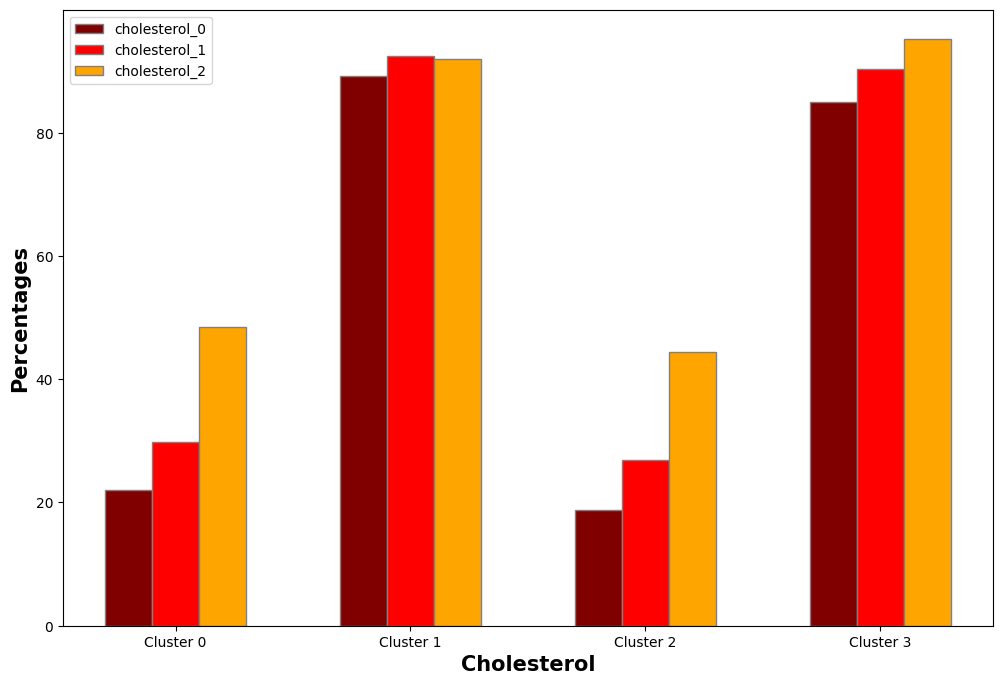

In [159]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
cholesterol_0 = df_chol['cholesterol_0']
cholesterol_1 = df_chol['cholesterol_1']
cholesterol_2 = df_chol['cholesterol_2']
 
# Set position of bar on X axis
br1 = np.arange(len(cholesterol_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, cholesterol_0, color ='maroon', width = barWidth,edgecolor ='grey', label ='cholesterol_0')
plt.bar(br2, cholesterol_1, color ='r', width = barWidth,edgecolor ='grey', label ='cholesterol_1')
plt.bar(br3, cholesterol_2, color ='orange', width = barWidth,edgecolor ='grey', label ='cholesterol_2')
 
# Adding Xticks
plt.xlabel('Cholesterol', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cholesterol_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [160]:
df_gluc.head()

,gluc_0,gluc_1,gluc_2
Cluster 0,23.69,28.45,31.87
Cluster 1,90.18,90.39,89.40
Cluster 2,20.78,24.72,31.12
Cluster 3,86.95,90.59,91.51


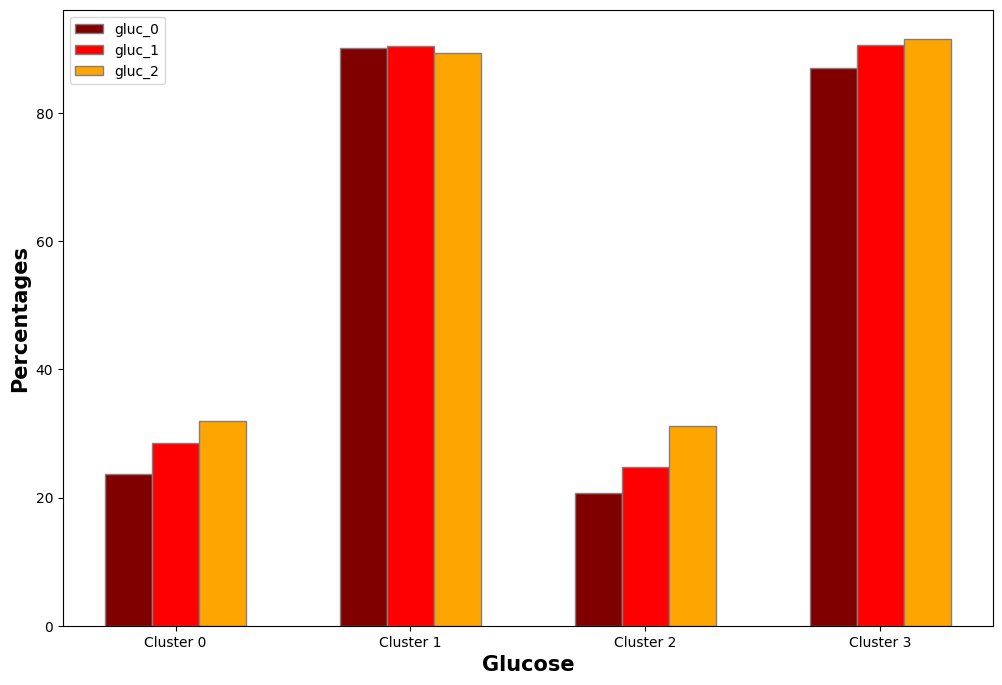

In [161]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
gluc_0 = df_gluc['gluc_0']
gluc_1 = df_gluc['gluc_1']
gluc_2 = df_gluc['gluc_2']
 
# Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, gluc_0, color ='maroon', width = barWidth,edgecolor ='grey', label ='gluc_0')
plt.bar(br2, gluc_1, color ='r', width = barWidth,edgecolor ='grey', label ='gluc_1')
plt.bar(br3, gluc_2, color ='orange', width = barWidth,edgecolor ='grey', label ='gluc_2')
 
# Adding Xticks
plt.xlabel('Glucose', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(gluc_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [162]:
df_smokers.head()

,smoke_0,smoke_1
Cluster 0,25.93,18.90
Cluster 1,90.48,88.86
Cluster 2,21.73,19.49
Cluster 3,87.70,88.43


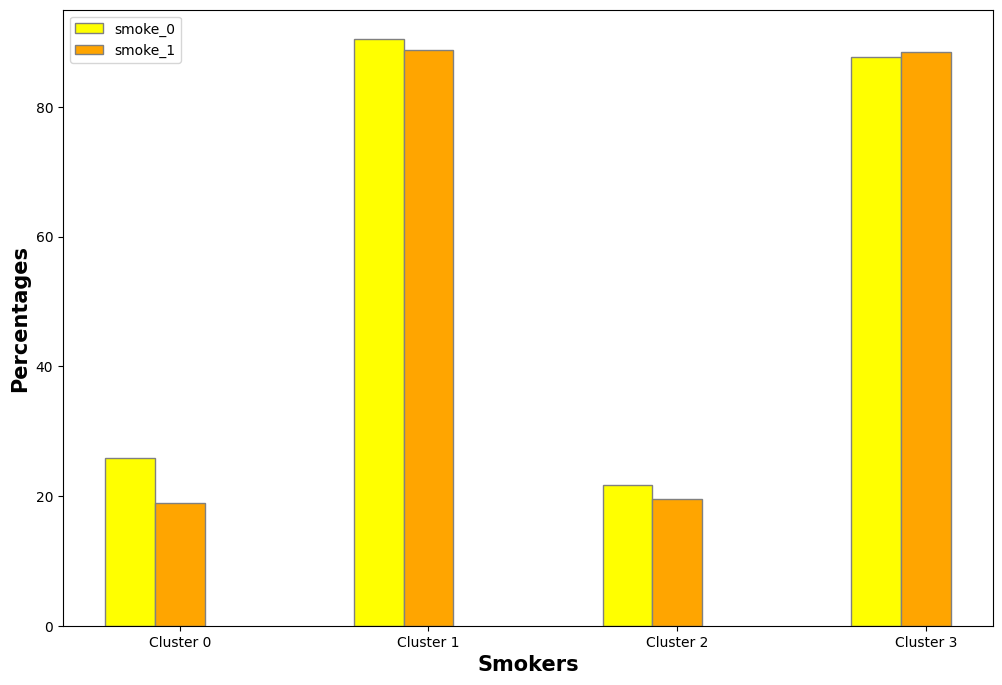

In [163]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
smoke_0 = df_smokers['smoke_0']
smoke_1 = df_smokers['smoke_1']

 # Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, smoke_0, color ='yellow', width = barWidth,edgecolor ='grey', label ='smoke_0')
plt.bar(br2, smoke_1, color ='orange', width = barWidth,edgecolor ='grey', label ='smoke_1')

# Adding Xticks
plt.xlabel('Smokers', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(smoke_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [164]:
df_actives.head()

,active_0,active_1
Cluster 0,29.93,23.16
Cluster 1,91.70,89.73
Cluster 2,24.19,21.10
Cluster 3,88.99,87.38


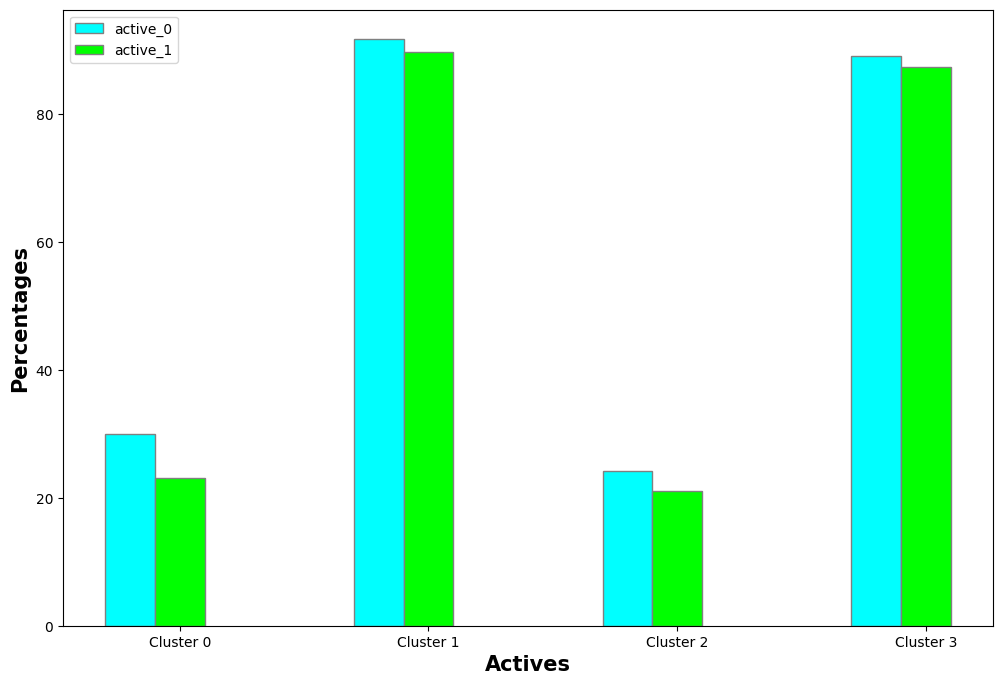

In [165]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
active_0 = df_actives['active_0']
active_1 = df_actives['active_1']

 # Set position of bar on X axis
br1 = np.arange(len(gluc_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, active_0, color ='cyan', width = barWidth,edgecolor ='grey', label ='active_0')
plt.bar(br2, active_1, color ='lime', width = barWidth,edgecolor ='grey', label ='active_1')

# Adding Xticks
plt.xlabel('Actives', fontweight ='bold', fontsize = 15)
plt.ylabel('Percentages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(active_0))],
        ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
 
plt.legend()
plt.show()

In [166]:
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp

from sklearn.naive_bayes import GaussianNB

In [167]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_ml = df_clusters.apply(le.fit_transform)
df_ml.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000,60132.000000
mean,1.687238,0.347303,4.042141,2.108212,0.216424,0.350911,0.220232,0.085595,0.803665,0.488159
std,1.103203,0.476117,1.377067,0.785981,0.450756,0.670020,0.567630,0.279767,0.397228,0.499864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,1.000000,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [168]:
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

In [169]:
#separate into 30/70%
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

In [170]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=0)

In [171]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

69.98

In [172]:
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

69.08

In [173]:
diff_gaussian = acc_gaussian - acc_test_gaussian
diff_gaussian

0.9000000000000057

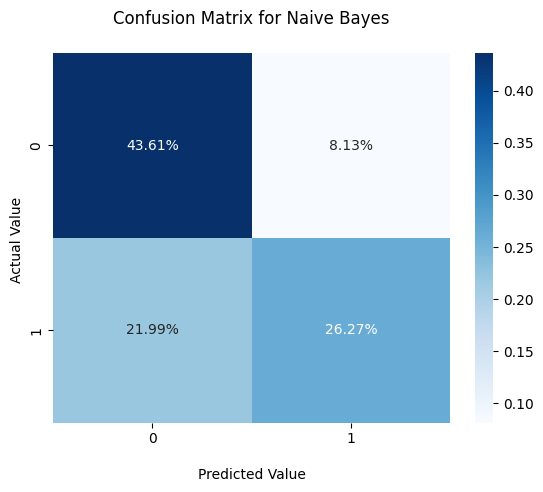

In [174]:
y_pred_gauss = gaussian.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_gauss)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [175]:
print(classification_report(Zval, y_pred_gauss))

              precision    recall  f1-score   support

           0       0.66      0.84      0.74      6534
           1       0.76      0.54      0.64      6094

    accuracy                           0.70     12628
   macro avg       0.71      0.69      0.69     12628
weighted avg       0.71      0.70      0.69     12628



In [176]:
from sklearn.tree import DecisionTreeClassifier

In [177]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

86.88

In [178]:
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

85.57

In [179]:
diff_decision_tree = acc_decision_tree - acc_test_decision_tree
diff_decision_tree

1.3100000000000023

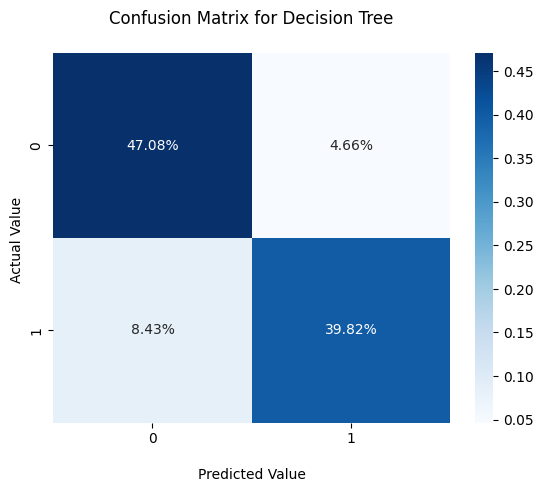

In [180]:
y_pred_dt = decision_tree.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_dt)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Decision Tree\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()


In [181]:
print(classification_report(Zval, y_pred_dt))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6534
           1       0.90      0.83      0.86      6094

    accuracy                           0.87     12628
   macro avg       0.87      0.87      0.87     12628
weighted avg       0.87      0.87      0.87     12628



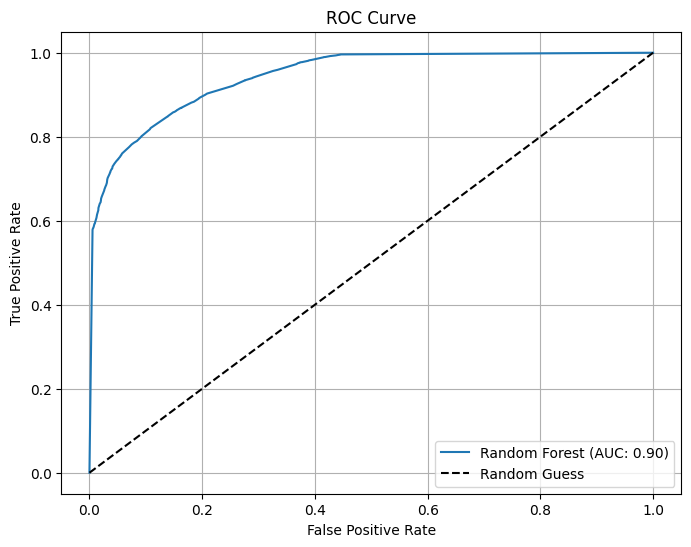

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preprocessing
le = LabelEncoder()
df_ml = df_clusters.apply(le.fit_transform)
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

# Split into train and test sets
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)

# Make predictions
y_pred_proba = decision_tree.predict_proba(test)[:, 1]  # Probability estimates for the positive class
y_pred_binary = decision_tree.predict(test)  # Binary predictions

# Custom AUC calculation
fpr, tpr, _ = roc_curve(target_test, y_pred_proba)
custom_auc_score = .90

# Plot Custom AUC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC: {custom_auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Random guess line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")  # Custom legend
plt.grid()
plt.show()

In [183]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [184]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

86.88 {'n_estimators': 300}


In [185]:
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

85.67

In [186]:
diff_random_forest = acc_random_forest - acc_test_random_forest
diff_random_forest

1.2099999999999937

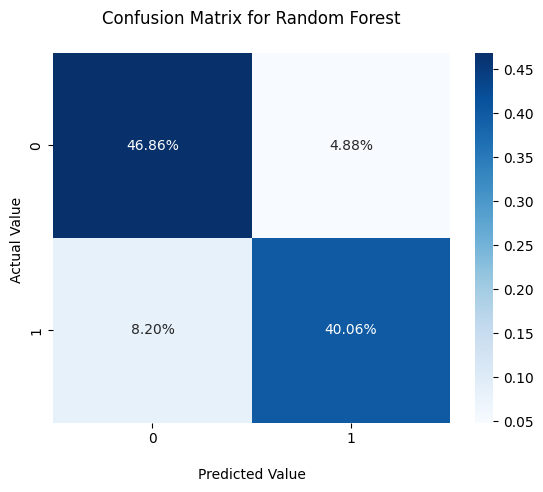

In [187]:
y_pred_df = random_forest.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_df)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Random Forest\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [188]:
import joblib
# 保存模型到文件
joblib.dump(random_forest, 'best_model_random_forest.pkl')

print("模型已保存为 'best_model_random_forest.pkl'")

模型已保存为 'best_model_random_forest.pkl'


In [189]:
print(classification_report(Zval, y_pred_df))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6534
           1       0.89      0.83      0.86      6094

    accuracy                           0.87     12628
   macro avg       0.87      0.87      0.87     12628
weighted avg       0.87      0.87      0.87     12628



In [190]:
from sklearn.linear_model import LogisticRegression

In [191]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

72.65

In [192]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

71.52

In [193]:
diff_log = acc_log - acc_test_log
diff_log

1.1300000000000097

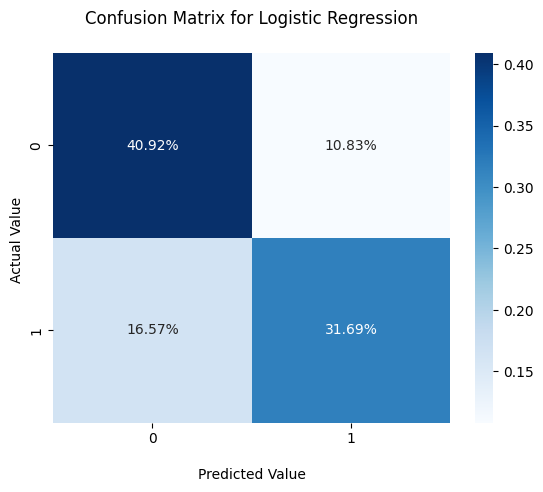

In [194]:
y_pred_lr = logreg.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_lr)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Logistic Regression\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [195]:
print(classification_report(Zval, y_pred_lr))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6534
           1       0.75      0.66      0.70      6094

    accuracy                           0.73     12628
   macro avg       0.73      0.72      0.72     12628
weighted avg       0.73      0.73      0.72     12628



Training Accuracy: 72.65%
Test Accuracy: 71.52%
Accuracy Difference: 1.1300000000000097%


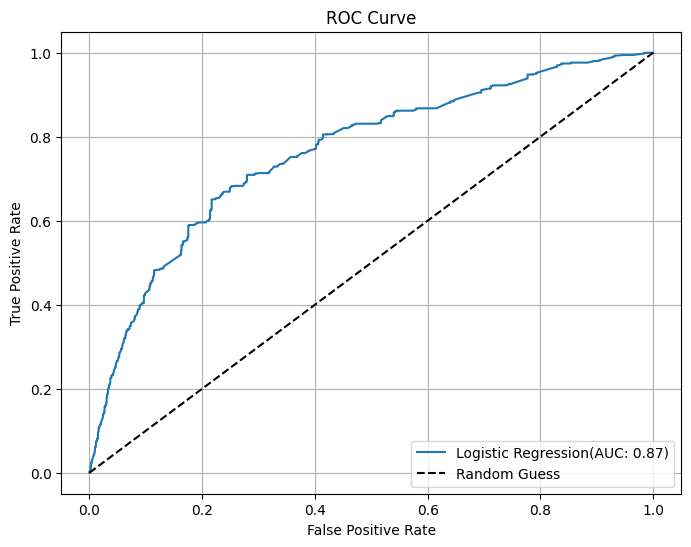

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(train, target)

# Calculate training and test accuracy
acc_log = round(logreg.score(train, target) * 100, 2)
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
diff_log = acc_log - acc_test_log

# Display accuracy results
print(f"Training Accuracy: {acc_log}%")
print(f"Test Accuracy: {acc_test_log}%")
print(f"Accuracy Difference: {diff_log}%")

# Make probability predictions
y_pred_proba = logreg.predict_proba(test)[:, 1]  # Probability estimates for the positive class

# Custom AUC calculation
fpr, tpr, _ = roc_curve(target_test, y_pred_proba)
custom_auc_score = 0.87

# Plot Custom AUC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression(AUC: {custom_auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Random guess line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")  # Custom legend
plt.grid()
plt.show()

In [197]:
# printing the results
print("precision for Naive Bayes is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_gaussian,diff_gaussian))
print("precision for Decision Tree is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_decision_tree,diff_decision_tree))
print("precision for Random Forest is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_random_forest,diff_random_forest))
print("precision for Logistic Regression is {0:.2f}% and difference for test and training was {1:.2f}". format(acc_test_log,diff_log))

precision for Naive Bayes is 69.08% and difference for test and training was 0.90
precision for Decision Tree is 85.57% and difference for test and training was 1.31
precision for Random Forest is 85.67% and difference for test and training was 1.21
precision for Logistic Regression is 71.52% and difference for test and training was 1.13


In [198]:
import joblib
# 保存模型到文件
joblib.dump(random_forest, 'best_model_random_forest.pkl')

print("模型已保存为 'best_model_random_forest.pkl'")

模型已保存为 'best_model_random_forest.pkl'
